<a href="https://colab.research.google.com/github/Muzi-HS/2023ML/blob/main/3%EB%B6%84_%EB%A7%8C%EC%97%90_%EB%A7%8C%EB%93%9C%EB%8A%94_%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5_%EC%84%9C%EB%B9%84%EC%8A%A4_%EB%B8%94%EB%9E%99%ED%95%91%ED%81%AC%EB%B6%84%EB%A5%98%EA%B8%B0_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <b>3분 만에 전이 학습(Transfer Learning)을 활용한 인공지능 서비스 만들기</b>

* 본 프로젝트에서는 세 가지 기능을 합쳐서 순식간에 상용 인공지능 서비스를 제작합니다.
    1. 이미지 크롤링(image crawling) 혹은 크롤링 라이브러리
    2. 전이 학습(transfer learning)
    3. 웹 API 개발
* 이 프로젝트에서 만들어 볼 것은 <b>마동석/김종국/이병헌</b> 분류기(classifier)입니다.
* 단 <b>3분</b> 만에 인공지능 개발의 전체 과정을 진행합니다.
    * 데이터 수집/정제
    * 인공지능 모델 학습
    * 학습된 모델 배포
* 한글 폰트 설치 이후에 <b>[런타임] - [런타임 다시 시작]</b>을 수행해야 합니다.

In [ ]:
# 한글 폰트 설치하기 (꼭! 설치가 완료되면 [런타임 다시 시작]을 누르고 다시 실행하기)
!apt install fonts-nanum -y

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정하기
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
#matplotlib.font_manager._rebuild()

!pip install koreanize-matplotlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (9,920 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 122545 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20180306-3_all.deb ...
Unpacking fonts-nanum (20180306-3) ...
Setting up fonts-nanum (20180306-3) ...
Processing triggers for fontconfig (2.13.1-2ubuntu3) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 63.3 MB/s eta 0:00:00


In [ ]:
import koreanize_matplotlib

In [ ]:
# 필요한 라이브러리 설치하기
!git clone https://github.com/ndb796/bing_image_downloader

Cloning into 'bing_image_downloader'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 86 (delta 17), reused 10 (delta 10), pack-reused 64
Unpacking objects: 100% (86/86), 17.48 KiB | 994.00 KiB/s, done.


#### <b>1. 이미지 크롤링을 활용한 학습 이미지 수집</b>

* 수집한 이미지를 저장하기 위한 폴더를 생성하고, 필요한 함수를 정의합니다.

In [ ]:
#train/test 분할

import os
import shutil
from bing_image_downloader.bing_image_downloader import downloader


directory_list = [
    './custom_dataset/train/',
    './custom_dataset/test/',
]

# 초기 디렉토리 만들기
for directory in directory_list:
    if not os.path.isdir(directory):
        os.makedirs(directory)

# 수집한 이미지를 학습 데이터와 평가 데이터로 구분하는 함수
def dataset_split(query, train_cnt):
    # 학습 및 평가 데이터셋 디렉토리 만들기
    for directory in directory_list:
        if not os.path.isdir(directory + '/' + query):
            os.makedirs(directory + '/' + query)
    # 학습 및 평가 데이터셋 준비하기
    cnt = 0
    for file_name in os.listdir(query):
        if cnt < train_cnt:
            print(f'[Train Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/train/' + query + '/' + file_name)
        else:
            print(f'[Test Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/test/' + query + '/' + file_name)
        cnt += 1
    shutil.rmtree(query)

In [ ]:
# train,val, test 분할
import random
import shutil
import os
from bing_image_downloader.bing_image_downloader import downloader

def dataset_split(query, train_ratio, val_ratio):
    # 학습, 검증, 테스트 데이터셋 디렉토리 만들기
    for directory in ['train', 'val', 'test']:
        if not os.path.isdir(directory + '/' + query):
            os.makedirs(directory + '/' + query)

    file_list = os.listdir(query)
    random.shuffle(file_list)

    total_files = len(file_list)
    train_cnt = int(total_files * train_ratio)
    val_cnt = int(total_files * val_ratio)

    train_files = file_list[:train_cnt]
    val_files = file_list[train_cnt:train_cnt + val_cnt]
    test_files = file_list[train_cnt + val_cnt:]

    for file_name in train_files:
        print(f'[Train Dataset] {file_name}')
        shutil.move(query + '/' + file_name, './train/' + query + '/' + file_name)

    for file_name in val_files:
        print(f'[Validation Dataset] {file_name}')
        shutil.move(query + '/' + file_name, './val/' + query + '/' + file_name)

    for file_name in test_files:
        print(f'[Test Dataset] {file_name}')
        shutil.move(query + '/' + file_name, './test/' + query + '/' + file_name)

    shutil.rmtree(query)

In [ ]:
# LOOCV
def loocv_split(query):
    # 학습, 검증, 테스트 데이터셋 디렉토리 만들기
    for directory in ['train', 'val', 'test']:
        if not os.path.isdir(directory + '/' + query):
            os.makedirs(directory + '/' + query)

    file_list = os.listdir(query)
    random.shuffle(file_list)
    total_files = len(file_list)

    for i, file_name in enumerate(file_list):
        if i < total_files - 1:
            print(f'[Train Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './train/' + query + '/' + file_name)
        else:
            print(f'[Validation Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './val/' + query + '/' + file_name)

* <b>마동석</b> 이미지 크롤링을 진행하고 데이터셋을 구축합니다.

In [ ]:
query = '로제'
downloader.download(query, limit=40,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 0.7, 0.2)
# dataset_split(query)

[Info] Indexing page: 1
[Info] Indexed 35 Images on Page 1.
#1 이미지 다운로드 (https://i0.wp.com/blackpinkupdate.com/wp-content/uploads/2019/06/1-BLACKPINK-Rose-Instagram-Update-7-June-2019.jpg?fit=1080%2C1349&amp;ssl=1)
#1 파일 다운로드가 완료되었습니다.
#2 이미지 다운로드 (https://img.marieclairekorea.com/2021/04/mck_60867ae03fa5d.jpg)
#2 파일 다운로드가 완료되었습니다.
#3 이미지 다운로드 (https://blog.kakaocdn.net/dn/c2o87P/btqDJfk44PT/3kh41qkrSIky7JrqXMP591/img.jpg)
#3 파일 다운로드가 완료되었습니다.
#4 이미지 다운로드 (https://mblogthumb-phinf.pstatic.net/MjAxODA2MjFfMjg0/MDAxNTI5NTQ3MDEyNDY5.FuVGy0lM-g_QQMzdoWXask6eVLtSMBy0TDq-0tbEEf8g.P3F4YD_shxVkmOoFgXrJQBBzh9Y8BCfkQLMu0nL2H8Ag.JPEG.pola0216/로제배경화면06.jpg?type=w800)
[Info] Issue getting: https://mblogthumb-phinf.pstatic.net/MjAxODA2MjFfMjg0/MDAxNTI5NTQ3MDEyNDY5.FuVGy0lM-g_QQMzdoWXask6eVLtSMBy0TDq-0tbEEf8g.P3F4YD_shxVkmOoFgXrJQBBzh9Y8BCfkQLMu0nL2H8Ag.JPEG.pola0216/로제배경화면06.jpg?type=w800
[Error] 'ascii' codec can't encode characters in position 147-152: ordinal not in range(128)
#4 이미지 다운로드 (http:/

* <b>김종국</b> 이미지 크롤링을 진행하고 데이터셋을 구축합니다.

In [ ]:
query = '지수'
downloader.download(query, limit=40,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 0.7, 0.2)

[Info] Indexing page: 1
[Info] Indexed 35 Images on Page 1.
#1 이미지 다운로드 (https://data2.bepick.net/bbs/2019/09/d9ea864b0430f5fdb5b3fc7b9b5e9127_20190915024240.jpg)
#1 파일 다운로드가 완료되었습니다.
#2 이미지 다운로드 (https://1.bp.blogspot.com/-w-BZBELysO0/X8XBLPwI_TI/AAAAAAAABBA/RjDwIWm0mLA9nHpK_XwbuhqG68drWFXEwCLcBGAsYHQ/s1670/download.png)
#2 파일 다운로드가 완료되었습니다.
#3 이미지 다운로드 (https://rare-gallery.com/uploads/posts/346249-BLACKPINK-Kpop-K-pop-Girls-Jisoo-Kim-Ji-soo-Beautiful-Vogue-Photoshoot-Photo-shoot-Lipstick.jpg)
[Info] Issue getting: https://rare-gallery.com/uploads/posts/346249-BLACKPINK-Kpop-K-pop-Girls-Jisoo-Kim-Ji-soo-Beautiful-Vogue-Photoshoot-Photo-shoot-Lipstick.jpg
[Error] HTTP Error 403: Forbidden
#3 이미지 다운로드 (http://www.onlifezone.com/files/attach/images/6006007/678/743/017/de31e69b267908e9cbf7da41a76384e5.jpg)
#3 파일 다운로드가 완료되었습니다.
#4 이미지 다운로드 (http://postfiles5.naver.net/MjAxNzAxMTdfMzAg/MDAxNDg0NjIzMzIwODcy.Ntvx4tLXwer9-SgeT0g2nFvOYe5H0OMm6MJbvHc2EGcg.noMrH-lCz-97FXL3KiKLzdOrkqEds5o3ks87PWA

* <b>이병헌</b> 이미지 크롤링을 진행하고 데이터셋을 구축합니다.

In [ ]:
query = '리사'
downloader.download(query, limit=40,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 0.7, 0.2)

[Info] Indexing page: 1
[Info] Indexed 37 Images on Page 1.
#1 이미지 다운로드 (https://img.sbs.co.kr/newsnet/etv/upload/2022/03/29/30000751780_1280.jpg)
#1 파일 다운로드가 완료되었습니다.
#2 이미지 다운로드 (https://i.pinimg.com/736x/78/07/1d/78071d31e5fa255f2621c12790edae87.jpg)
#2 파일 다운로드가 완료되었습니다.
#3 이미지 다운로드 (https://gifsf.com/files/attach/images/332597/072/450/003/2c67936e8d0f91edbb60953e3d607b8f.jpg)
#3 파일 다운로드가 완료되었습니다.
#4 이미지 다운로드 (https://image.ytn.co.kr/general/jpg/2018/0604/201806041306134498_d.jpg)
#4 파일 다운로드가 완료되었습니다.
#5 이미지 다운로드 (https://1.bp.blogspot.com/-22HtPHQSmfI/XzNNFCOYgFI/AAAAAAAAMnc/xtnEiTGJA2o15aVdBPxZ70yDPNkqfJqggCLcBGAsYHQ/s1600/4.gif)
#5 파일 다운로드가 완료되었습니다.
#6 이미지 다운로드 (https://www.bing.com/th/id/OGC.217c9140dca411a41adad8db173d1877?pid=1.7&amp;rurl=https%3a%2f%2f1.bp.blogspot.com%2f-22HtPHQSmfI%2fXzNNFCOYgFI%2fAAAAAAAAMnc%2fxtnEiTGJA2o15aVdBPxZ70yDPNkqfJqggCLcBGAsYHQ%2fs1600%2f4.gif&amp;ehk=F50GgJ5%2f%2b4IucAYwQVKM4kCzL4UBmtm%2fUY3A4sd%2f1D4%3d)
[Info] Issue getting: https://www.bing.co

In [ ]:
query = '제니'
downloader.download(query, limit=40,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 0.7, 0.2)

[Info] Indexing page: 1
[Info] Indexed 35 Images on Page 1.
#1 이미지 다운로드 (https://1.bp.blogspot.com/-Tua1MXTw1SM/YJyNm-AAHGI/AAAAAAACJjc/9UPRil5otKssML2RkardNyLSUzL_8bRXQCLcBGAsYHQ/s0/pic_009.jpg)
#1 파일 다운로드가 완료되었습니다.
#2 이미지 다운로드 (https://blog.kakaocdn.net/dn/bEMscG/btqC487CI52/kmkCYD6kGggwOjnjqWKDRk/img.jpg)
#2 파일 다운로드가 완료되었습니다.
#3 이미지 다운로드 (http://img.etoday.co.kr/pto_db/2016/11/20161119080643_974737_600_900.jpg)
#3 파일 다운로드가 완료되었습니다.
#4 이미지 다운로드 (https://t1.daumcdn.net/thumb/R1024x0/?fname=http://cfile259.uf.daum.net/image/993161395C2B335E2319A6)
#4 파일 다운로드가 완료되었습니다.
#5 이미지 다운로드 (https://1.bp.blogspot.com/-p8qEOdEY9mM/YJyNlCAd2KI/AAAAAAACJjA/RckikukXVag_wOHhERbUrJT32W5r2P2FwCLcBGAsYHQ/s0/pic_002.jpg)
#5 파일 다운로드가 완료되었습니다.
#6 이미지 다운로드 (https://fimg4.pann.com/new/download.jsp?FileID=46429067)
#6 파일 다운로드가 완료되었습니다.
#7 이미지 다운로드 (https://image.ytn.co.kr/osen/2020/08/872879c9-0598-49c8-acbd-ca0e996a274b.jpg)
[Error] Invalid image, not saving https://image.ytn.co.kr/osen/2020/08/872879c9-0598-

#### <b>2. PyTorch를 이용한 전이 학습(Transfer Learning)</b>

* 전이 학습(transfer learning)의 동작 과정을 간략화한 것은 다음과 같습니다.

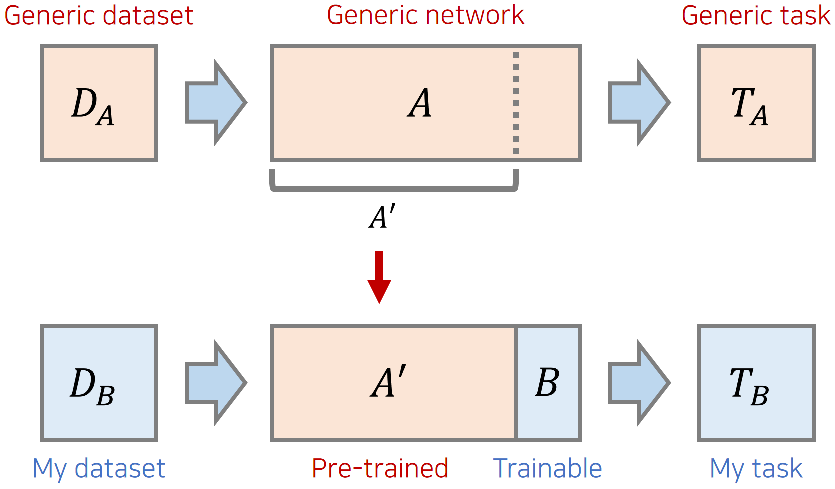

* 학습을 위해 필요한 라이브러리를 불러옵니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

* 데이터셋을 불러옵니다.

In [ ]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])

data_dir = '/content'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)
val_datasets = datasets.ImageFolder(os.path.join(data_dir, 'val'), transforms_val)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))
print('val 데이터셋 크기:', len(val_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 111
테스트 데이터셋 크기: 15
val 데이터셋 크기: 32
클래스: ['로제', '리사', '제니', '지수']


* 간단히 이미지를 시각화해 봅시다.

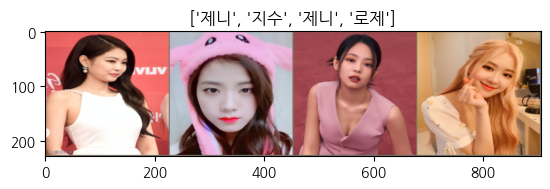

In [ ]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

* 학습할 CNN 딥러닝 모델 객체를 초기화합니다.

In [ ]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 406MB/s]


* 학습을 진행합니다.

In [ ]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 1.4206 Acc: 31.5315% Time: 10.8545s
#1 Loss: 0.8255 Acc: 68.4685% Time: 14.3749s
#2 Loss: 0.3296 Acc: 92.7928% Time: 18.8773s
#3 Loss: 0.2092 Acc: 93.6937% Time: 22.6678s
#4 Loss: 0.3695 Acc: 84.6847% Time: 26.6513s
#5 Loss: 0.4464 Acc: 85.5856% Time: 30.3956s
#6 Loss: 0.3270 Acc: 84.6847% Time: 34.7580s
#7 Loss: 0.5142 Acc: 83.7838% Time: 38.2424s
#8 Loss: 0.2123 Acc: 92.7928% Time: 41.6768s
#9 Loss: 0.2100 Acc: 92.7928% Time: 46.5432s
#10 Loss: 0.3669 Acc: 84.6847% Time: 50.0027s
#11 Loss: 0.3449 Acc: 87.3874% Time: 53.5246s
#12 Loss: 0.1822 Acc: 93.6937% Time: 57.7040s
#13 Loss: 0.2930 Acc: 90.9910% Time: 61.7224s
#14 Loss: 0.2248 Acc: 94.5946% Time: 65.2809s
#15 Loss: 0.4571 Acc: 85.5856% Time: 68.7338s
#16 Loss: 0.1948 Acc: 93.6937% Time: 73.6565s
#17 Loss: 0.3143 Acc: 87.3874% Time: 77.2050s
#18 Loss: 0.0769 Acc: 97.2973% Time: 80.7094s
#19 Loss: 0.1776 Acc: 94.5946% Time: 85.1114s
#20 Loss: 0.0872 Acc: 96.3964% Time: 89.1257s
#21 Loss: 0.2553 Acc: 91.8919% Time: 92.5612

* 학습된 모델을 평가합니다.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[예측 결과: 제니] (실제 정답: 제니)


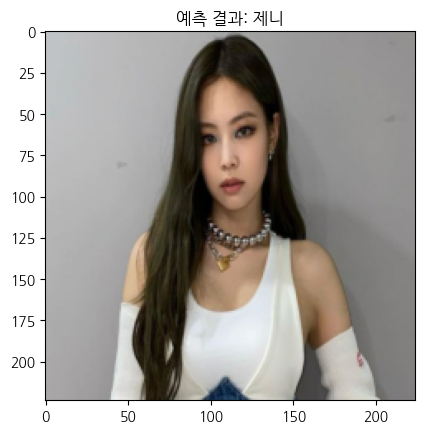

[예측 결과: 로제] (실제 정답: 로제)


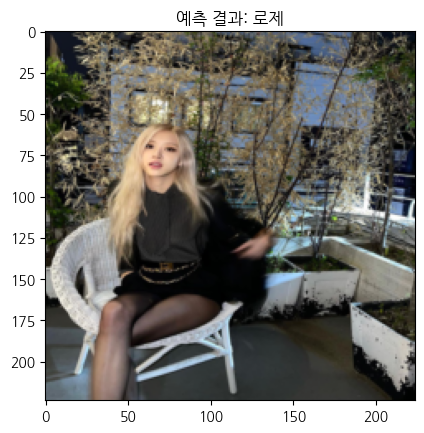

[예측 결과: 로제] (실제 정답: 로제)


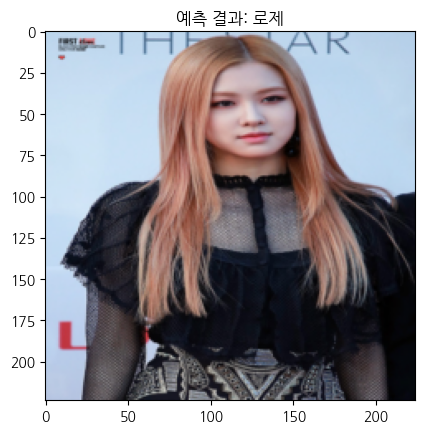

[예측 결과: 지수] (실제 정답: 지수)


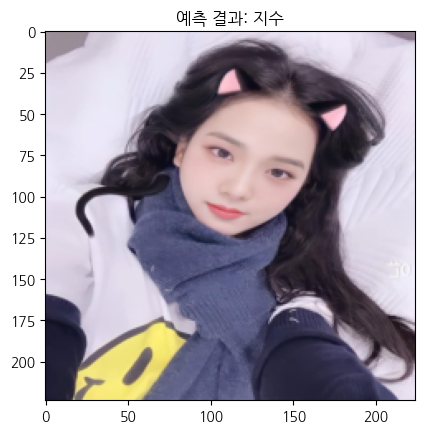

[예측 결과: 제니] (실제 정답: 제니)


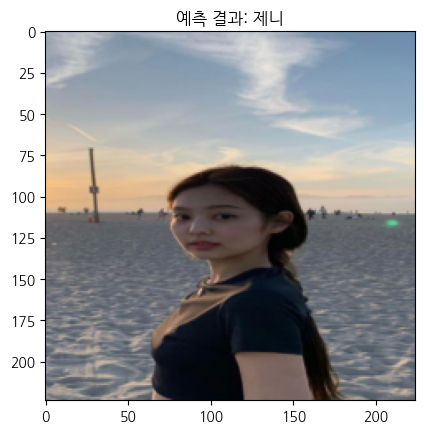

[예측 결과: 리사] (실제 정답: 리사)


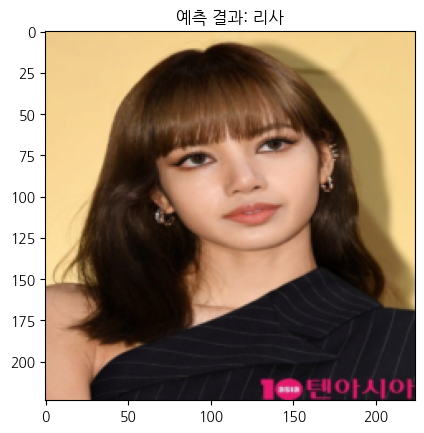

[예측 결과: 로제] (실제 정답: 로제)


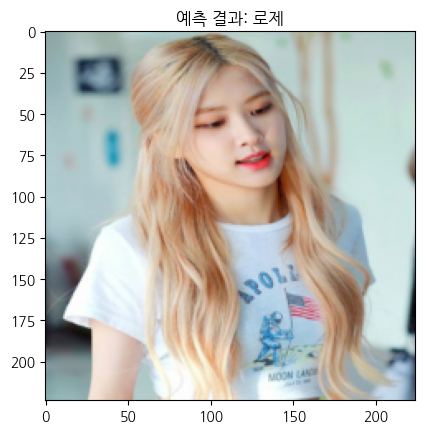

[예측 결과: 리사] (실제 정답: 리사)


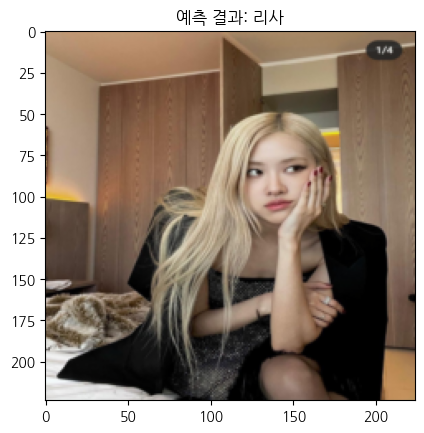

[Test Phase] Loss: 0.6457 Acc: 84.3750% Time: 3.2745s
(32, 4)


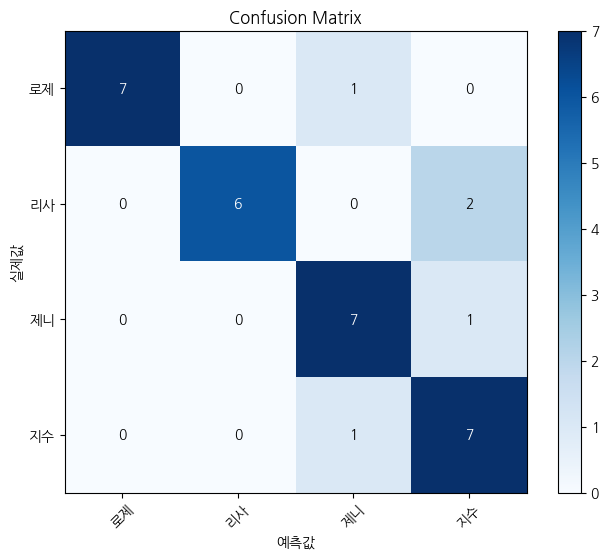

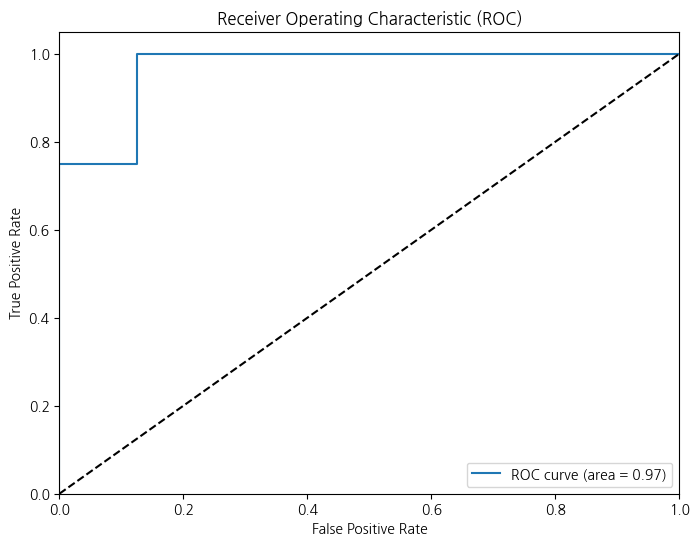

F1 스코어: 0.8479
Precision: 0.8694
Recall: 0.8438
Accuracy: 0.8438


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score

# ...

# 모델 검증(val) 여기서 하이퍼파라미터 조정...
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    all_preds = []  # 예측 값들을 저장할 리스트
    all_labels = []  # 실제 레이블들을 저장할 리스트
    probs = []  # 확률값을 저장할 리스트

    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        all_preds.extend(preds.cpu().numpy())  # 예측 값들을 리스트에 추가
        all_labels.extend(labels.data.cpu().numpy())  # 실제 레이블들을 리스트에 추가

        probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())  # 확률값들을 리스트에 추가

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(val_datasets)
    epoch_acc = running_corrects / len(val_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

    # `probs`와 `all_labels`의 길이를 확인하고 조정
    if len(probs) != len(all_labels):
        print("Error: Number of samples in `probs` and `all_labels` do not match.")
        exit()

    # `probs`의 shape 확인
    probs = np.array(probs)
    print(probs.shape)

# Confusion Matrix 계산
confusion = confusion_matrix(all_labels, all_preds)

# Precision 계산
precision = precision_score(all_labels, all_preds, average='macro')

# Recall 계산
recall = recall_score(all_labels, all_preds, average='macro')

# Accuracy 계산
accuracy = accuracy_score(all_labels, all_preds)

# Confusion Matrix 출력
plt.figure(figsize=(8, 6))
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('예측값')
plt.ylabel('실제값')
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, confusion[i, j], ha='center', va='center', color='white' if confusion[i, j] > np.max(confusion) / 2 else 'black')
plt.show()

# ROC Curve 계산 및 그리기
fpr, tpr, thresholds = roc_curve(all_labels, probs[:, 1], pos_label=1)  # ROC Curve 계산
roc_auc = auc(fpr, tpr)  # AUC 계산

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# F1 Score 계산
f1 = f1_score(all_labels, all_preds, average='macro')

print('F1 스코어: {:.4f}'.format(f1))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('Accuracy: {:.4f}'.format(accuracy))


#### <b>3. 분류 모델 API 개발</b>

* 학습된 분류 모델을 다른 사람이 사용할 수 있도록 API를 개발하여 배포합니다.
* 먼저 한 장의 이미지를 파일로부터 읽어와 분류 결과를 반환하는 기능을 작성합니다.

In [ ]:
# 테스트용 이미지 다운로드하기
!wget https://upload.wikimedia.org/wikipedia/commons/f/f1/Don_Lee_by_Gage_Skidmore.jpg -O test_image.jpg

--2023-05-21 06:33:27--  https://upload.wikimedia.org/wikipedia/commons/f/f1/Don_Lee_by_Gage_Skidmore.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4070584 (3.9M) [image/jpeg]
Saving to: ‘test_image.jpg’

test_image.jpg      100%[===================>]   3.88M  19.0MB/s    in 0.2s    

2023-05-21 06:33:28 (19.0 MB/s) - ‘test_image.jpg’ saved [4070584/4070584]



In [ ]:
from PIL import Image


image = Image.open('test_image.jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

NameError: ignored

* 웹 API 개방을 위해 <b>Ngrok</b> 서비스를 이용합니다.
* API 기능 제공을 위해 <b>Flask 프레임워크</b>를 사용합니다.

In [ ]:
# 필요한 라이브러리 설치하기
!pip install flask-ngrok

In [ ]:
import io
from flask_ngrok import run_with_ngrok
from flask import Flask, jsonify, request


# 이미지를 읽어 결과를 반환하는 함수
def get_prediction(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    image = transforms_test(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    return class_names[preds[0]]


app = Flask(__name__)


@app.route('/', methods=['POST'])
def predict():
    if request.method == 'POST':
        # 이미지 바이트 데이터 받아오기
        file = request.files['file']
        image_bytes = file.read()

        # 분류 결과 확인 및 클라이언트에게 결과 반환
        class_name = get_prediction(image_bytes=image_bytes)
        print("결과:", {'class_name': class_name})
        return jsonify({'class_name': class_name})

* API를 개방할 수 있으며 실행할 때마다 서버의 주소가 변경됩니다.
* 서버 주소를 정확히 확인할 필요가 있습니다.

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://c4cdb8de3a35.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


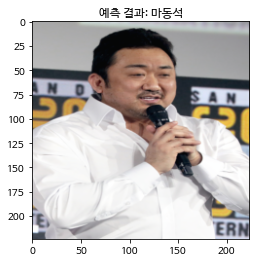

127.0.0.1 - - [23/Feb/2021 08:06:33] "POST / HTTP/1.1" 200 -


결과: {'class_name': '마동석'}


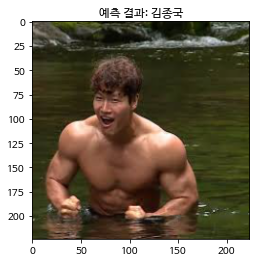

127.0.0.1 - - [23/Feb/2021 08:06:51] "POST / HTTP/1.1" 200 -


결과: {'class_name': '김종국'}


In [ ]:
run_with_ngrok(app)
app.run()

* 클라이언트 테스트 방법

<pre>
curl -X POST -F file=@{이미지 파일명} {Ngrok 서버 주소}
</pre>

* 사용 예시

<pre>
curl -X POST -F file=@dongseok.jpg http://c4cdb8de3a35.ngrok.io/
</pre>

* 이러한 방식으로 웹, 모바일, 게임 등의 소프트웨어 환경에서 API를 호출하는 방식으로 인공지능 앱을 개발할 수 있습니다.